In [1]:
import sympy as sp
import numpy as np
import plotly.graph_objects as go

# Define the scaling law parameters
E, A, B, alpha, beta = 1.69, 406.4, 410.7, 0.32, 0.28

# Define the compute budget for a 70B parameter model trained on 20T tokens
C_70B = 6 * 70e9 * 20e12

# Define the symbolic variables
N_opt, D_opt, k_N, k_D = sp.symbols('N_opt D_opt k_N k_D')

# Define the scaling law equation
eq = sp.Eq(sp.Pow(k_D, -beta), 1 - (sp.Pow(k_N, -alpha) - 1) * A * sp.Pow(N_opt, -alpha) / (B * sp.Pow(D_opt, -beta)))

# Solve for k_D
k_D_sol = sp.solve(eq, k_D)[0]

# Define the equations for C_new and C_overhead
C_initial = 6 * N_opt * D_opt
C_new = 6 * (k_N * N_opt) * (k_D_sol * D_opt)
C_overhead = ((C_new - C_initial) / C_initial) * 100

In [11]:
C_new

2.05491689294308e+54*D_opt*N_opt*k_N*(N_opt**0.32*k_N**0.32/(966337959581201.0*D_opt**0.28*k_N**0.32 - 966337959581201.0*D_opt**0.28 + 976562500000000.0*N_opt**0.32*k_N**0.32))**(25/7)

In [2]:
# Calculate the compute overhead for various model sizes
model_sizes = [40e9, 50e9, 60e9, 70e9, 80e9, 100e9, 150e9]
k_N_values = [size / 70e9 for size in model_sizes]
G = (alpha * A / (beta * B))**(1/(alpha + beta))
N_opt_val = G * (C_70B / 6)**(beta / (alpha + beta))
D_opt_val = G**(-1) * (C_70B / 6)**(alpha / (alpha + beta))

In [10]:
D_opt_val

6150353054354.077

In [14]:
compute_overheads = []
k_D_values = []
for k_N_val in k_N_values:
    
    k_D_val = k_D_sol.subs([(N_opt, N_opt_val), (D_opt, D_opt_val), (k_N, k_N_val)])
    C_overhead_val = C_overhead.subs([(N_opt, N_opt_val), (D_opt, D_opt_val), (k_N, k_N_val), (k_D, k_D_val)])
    compute_overheads.append(float(C_overhead_val))
    k_D_values.append(float(k_D_val))

In [16]:
# compute_overheads = [float(x) for x in compute_overheads]

In [17]:
k_D_values

[1.9588330077521112,
 1.4538132079478414,
 1.1754114839946646,
 0.9999999999999909,
 0.8795162147875502,
 0.7246246877358272,
 0.5382841995306356]

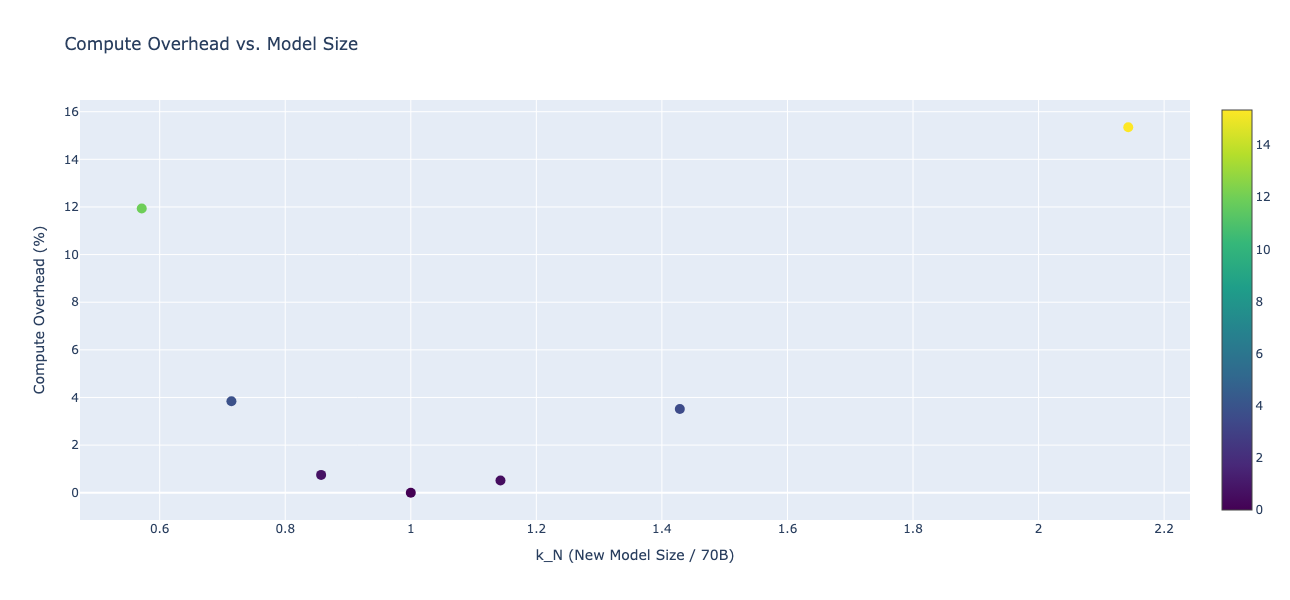

In [18]:

# Create the Plotly figure
fig = go.Figure()

# Add the scatter plot
fig.add_trace(go.Scatter(
    x=k_N_values,
    y=compute_overheads,
    mode='markers',
    marker=dict(size=10, color=compute_overheads, colorscale='Viridis', showscale=True),
    # text=[f"Model Size: {size/1e9:.1f}B<br>Compute Overhead: {overhead:.2f}%<br>k_N: {k_N:.2f}" for size, overhead, k_N in zip(model_sizes, compute_overheads, k_N_values)],
    text=[f"Model Size: {size/1e9:.1f}B<br>Compute Overhead: {overhead:.2f}%<br>k_N: {k_N:.2f}<br>k_D: {k_D:.2f}" for size, overhead, k_N, k_D in zip(model_sizes, compute_overheads, k_N_values, k_D_values)],
    hoverinfo='text'
))

# Set the layout
fig.update_layout(
    title="Compute Overhead vs. Model Size",
    xaxis_title="k_N (New Model Size / 70B)",
    yaxis_title="Compute Overhead (%)",
    width=800,
    height=600
)

# Show the plot
fig.show()